## Image segmentation with Camvid

In [0]:
# Magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Imports
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import * 
from fastai import *

The one Hundred Layer Tiramisu paper used a modified version of camvid, with smaller images and few classes. You can get it from the Camvid directory of this repo:

`git clone http://github.com/alexgkendall/SegNet-Tutorial.git`

In [3]:
! git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 37.18 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [4]:
ls

sample_data/  SegNet-Tutorial/


In [5]:
ls SegNet-Tutorial/

CamVid/  docker/  Example_Models/  Models/  README.md  Scripts/


In [0]:
path = Path('./SegNet-Tutorial/CamVid')

In [7]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/testannot'),
 PosixPath('SegNet-Tutorial/CamVid/train')]

## Data

In [0]:
fnames = get_image_files(path/'train')

In [9]:
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/train/0016E5_00390.png'),
 PosixPath('SegNet-Tutorial/CamVid/train/0001TP_007860.png'),
 PosixPath('SegNet-Tutorial/CamVid/train/0016E5_06660.png')]

In [10]:
lbl_names = get_image_files(path/'trainannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/trainannot/0016E5_00390.png'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot/0001TP_007860.png'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot/0016E5_06660.png')]

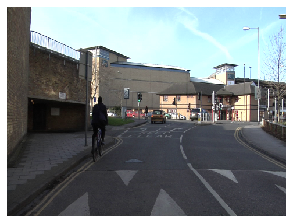

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize = (5, 7))

In [0]:
def get_y_fn(x): return Path(str(x.parent) + 'annot')/x.name
# For 'SegNet-Tutorial/CamVid/train/0006R0_f02190.png'
# x.parent returns SegNet-Tutorial/CamVid/train and 
# x.name returns 0006R0_f02190.png
codes = array(['Sky', 'Building', 'Pole', 'Road', 'SideWalk', 'Tree', 'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [13]:
codes.shape

(12,)

In [0]:
# mask = open_image(get_y_fn(img_f))
# mask.show()

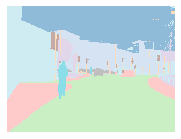

In [15]:
mask = open_mask(get_y_fn(img_f))
mask.show()

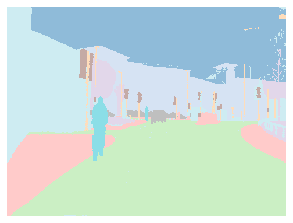

In [16]:
mask.show(figsize=(5, 7))

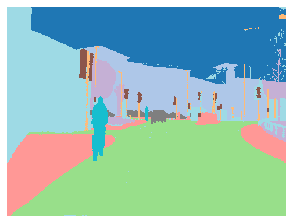

In [17]:
mask.show(figsize=(5, 6), alpha = 1)

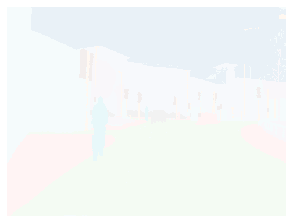

In [18]:
mask.show(figsize=(5, 7), alpha = 0.1)

alpha seems basically like brightness but technically it's the aount of opacity.

In [0]:
?plt.imshow

In [0]:
?mask.show

In [21]:
doc(mask.show)

In [22]:
mask.shape

torch.Size([1, 360, 480])

In [23]:
src_size = np.array(mask.shape[1:]) # Doing the work of squeezing
src_size, mask.data

(array([360, 480]), tensor([[[11, 11, 11,  ..., 11, 11, 11],
          [11, 11, 11,  ..., 11, 11, 11],
          [11, 11, 11,  ..., 11, 11, 11],
          ...,
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3]]]))

## Datasets

In [0]:
bs, size = 8, src_size//2

In [0]:
src = (SegmentationItemList.from_folder(path)
.split_by_folder(valid='val')
.label_from_func(get_y_fn, classes = codes)
)

In [0]:
data = (src.transform(get_transforms(), tfm_y = True)
.databunch(bs=bs)
.normalize(imagenet_stats)
)

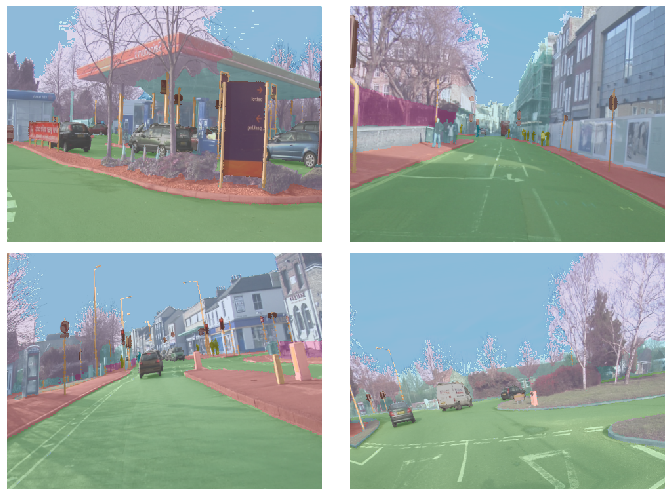

In [27]:
data.show_batch(2, figsize = (10, 7))

## Model

In [0]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

In [0]:
# As explained in the original paper
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
metrics = acc_camvid
wd = 1e-2

In [0]:
# What is bottle? I didn't understand.
learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd, bottle = True)

In [0]:
?unet_learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


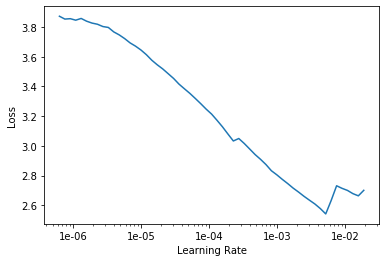

In [58]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(1e-4, 1e-3)

In [60]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.609260,1.042980,0.753108,00:26
1,1.003001,0.691105,0.822989,00:26
2,0.748304,0.570629,0.841130,00:26
3,0.647462,0.544972,0.853055,00:26
4,0.547562,0.465533,0.867098,00:26
5,0.489329,0.403295,0.878728,00:26
6,0.442003,0.547065,0.822459,00:25
7,0.412812,0.323474,0.900697,00:25
8,0.362767,0.282252,0.913138,00:25
9,0.318399,0.267792,0.916681,00:25


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


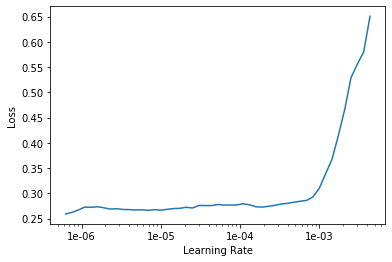

In [63]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(1e-5, 1e-4)

In [65]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.272651,0.267624,0.914348,00:27
1,0.270329,0.256237,0.920469,00:27
2,0.267766,0.261559,0.919498,00:27
3,0.263446,0.256482,0.919192,00:27
4,0.258020,0.258993,0.919769,00:26
5,0.248795,0.253818,0.926652,00:27
6,0.242360,0.235444,0.929696,00:27
7,0.235888,0.275419,0.914220,00:27
8,0.225830,0.240562,0.932899,00:26
9,0.216441,0.231949,0.929993,00:27


In [0]:
learn.save('stage-2')

## Go big

In [0]:
# Garbage collection... need to learn more about this
?gc.collect()

In [67]:
learn = None
gc.collect() # Always do this before starting training

6000

In [68]:
gpu_mem_get_free_no_cache()

15399

In [0]:
size = src_size
bs = 8

In [0]:
data = (src.transform(get_transforms(), size = size, tfm_y = True)
.databunch(bs=bs)
.normalize(imagenet_stats)
)

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd = wd, bottle = True)

In [72]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: SegNet-Tutorial/CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


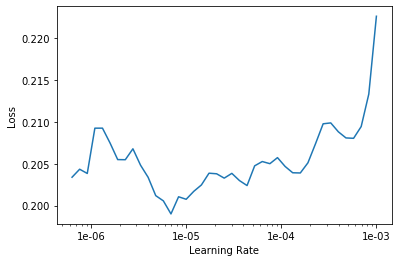

In [73]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-5

In [75]:
learn.fit_one_cycle(10, slice(lr), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.208979,0.234288,0.929945,00:26
1,0.206869,0.236989,0.929714,00:26
2,0.207226,0.236593,0.929808,00:26
3,0.204736,0.233861,0.930742,00:26
4,0.203272,0.239944,0.928971,00:26
5,0.204580,0.234476,0.929938,00:26
6,0.202755,0.230627,0.932223,00:26
7,0.202924,0.236004,0.930600,00:26
8,0.201108,0.234607,0.931561,00:26
9,0.199061,0.234538,0.930419,00:26


In [0]:
learn.save('stage-1-big')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


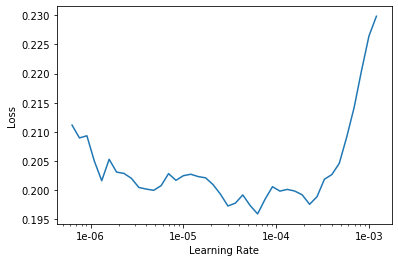

In [78]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(1e-5, 1e-4)

In [80]:
learn.fit_one_cycle(10, lrs, )

epoch,train_loss,valid_loss,acc_camvid,time
0,0.198876,0.239746,0.929735,00:27
1,0.203297,0.234651,0.931313,00:27
2,0.204026,0.231601,0.931787,00:27
3,0.201925,0.245555,0.924576,00:27
4,0.197368,0.224717,0.931496,00:27
5,0.192729,0.230464,0.932551,00:27
6,0.186417,0.238788,0.931712,00:27
7,0.181278,0.237182,0.931119,00:27
8,0.176254,0.232639,0.934201,00:27
9,0.174663,0.229023,0.934555,00:27


In [0]:
learn.save('stage-2-big')

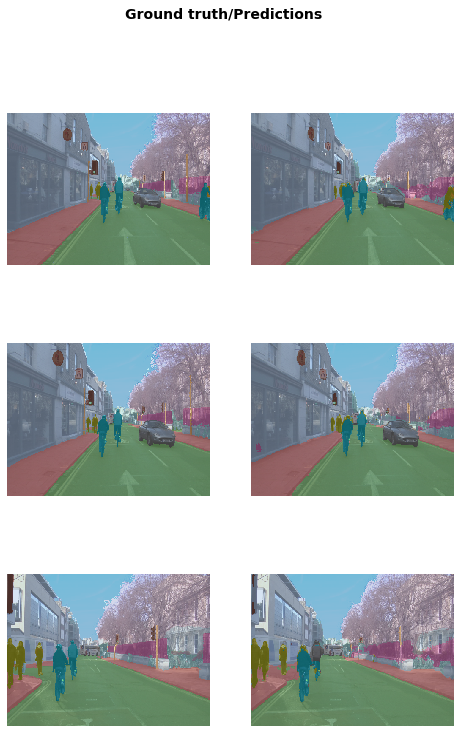

In [87]:
learn.show_results(rows = 3)

In [0]:
# start dimensions: 480x360

In [85]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________